In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 6s 0us/step


In [3]:
os.listdir(dataset_dir)

['README', 'train', 'imdb.vocab', 'imdbEr.txt', 'test']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['labeledBow.feat',
 'unsup',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'urls_neg.txt',
 'urls_unsup.txt']

In [5]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [6]:
os.listdir(train_dir)

['labeledBow.feat',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'urls_neg.txt',
 'urls_unsup.txt']

In [7]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split = 0.2,
    subset='training',
    seed=seed

)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f"Recenzja: {text_batch.numpy()[i]}")
    print(f"Etykieta: {label_batch.numpy()[i]}")

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [10]:
print(f'etykieta 0 -> {raw_train_ds.class_names[0]}')
print(f'etykieta 1 -> {raw_train_ds.class_names[1]}')

etykieta 0 -> neg
etykieta 1 -> pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split = 0.2,
    subset='validation',
    seed=seed

)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size

)

Found 25000 files belonging to 2 classes.


In [13]:
#standardyzacja danych tekstowych
def custom_standardization(input_data):
  lowercase=tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')

In [15]:
#wektoryzacja tesktu
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)


In [16]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [18]:
text_batch,label_batch = next(iter(raw_test_ds))
first_review,first_label = text_batch[0],label_batch[0]
print(f'recenzja: {first_review}')
print(f'etykieta: {first_label}')
print(f'widok zwektoryzowany:\n{vectorize_text(first_review,first_label)}')

recenzja: b"This movie has one of the worst lead characters ever. I say this because he is made out to be the hero when, in my opinion, everything he does in the whole movie screws up people's lives and causes problems. He can do nothing right, yet the movie makes him seem like the cool dude everyone should be looking up to. He has temper tantrums at all the wrong times, he has all the wrong stances on things that end up making people mad at him and getting people killed, he is too nosy, too pushy, too macho, too assuming, makes all the wrong decisions and has no common sense. <br /><br />It's about a private detective hired by a successful painter to find the woman and son that he walked out on years ago. The detective finds the woman and what he thinks to be her son. However, all kinds of things happen to make this story full of crime, drama and twists. It's made for TV, what do you expect?<br /><br />Anyhow, the movie is fairly entertaining. Johnny Depp is very young in this one and

In [22]:
print(f'15 -> {vectorize_layer.get_vocabulary()[15]}')
print(f'1 -> {vectorize_layer.get_vocabulary()[1]}')
print(f'5 -> {vectorize_layer.get_vocabulary()[5]}')
print(f'1287 -> {vectorize_layer.get_vocabulary()[1287]}')
print(f'313 -> {vectorize_layer.get_vocabulary()[313]}')
print(f'rozmiar słownika -> {len(vectorize_layer.get_vocabulary())}')

15 -> for
1 -> [UNK]
5 -> of
1287 -> silent
313 -> night
rozmiar słownika -> 10000


In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
#tworzenie modelu
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [32]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [33]:
epochs=10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6644 - binary_accuracy: 0.6915 - val_loss: 0.6109 - val_binary_accuracy: 0.7796
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5501 - binary_accuracy: 0.8000 - val_loss: 0.4868 - val_binary_accuracy: 0.8286
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.4461 - binary_accuracy: 0.8443 - val_loss: 0.4013 - val_binary_accuracy: 0.8616
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 0.3788 - binary_accuracy: 0.8651 - val_loss: 0.3480 - val_binary_accuracy: 0.8766
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3359 - binary_accuracy: 0.8783 - val_loss: 0.3118 - val_binary_accuracy: 0.8885
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3053 - binary_accuracy: 0.8892 - val_loss: 0.2849 - val_binary_accuracy: 0.8976
Epoch 7/10
625/625 [==============================] - 7s 

In [34]:
loss,accuracy = model.evaluate(test_ds)

782/782 [==============================] - 11s 14ms/step - loss: 0.3099 - binary_accuracy: 0.8737


In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

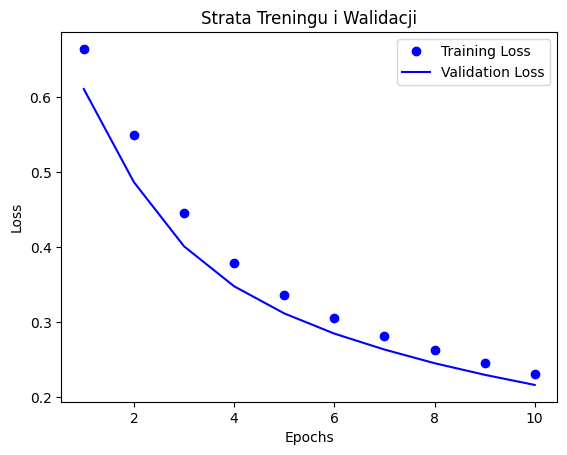

In [39]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)


plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')

plt.title('Strata Treningu i Walidacji')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')

])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 6s 7ms/step - loss: 0.3099 - accuracy: 0.8737
0.8737199902534485


In [44]:
testy = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible.",
    "Very bad movie!",
    "Big Shit!",
    "Disaster.",
    "Beautiful disaster",
    "Głupi film.",
    "The movie was bad bad bad bad bad bad",
    "The movie was okay okay okay okay okay okay okay okay.",
    "Great Great Great Great Great Great Great",
    "The movie was good with good acting but a poor screenplay."
]

In [45]:
export_model.predict(testy)

1/1 [==============================] - 0s 55ms/step


array([[0.6321312 ],
       [0.4574149 ],
       [0.36805204],
       [0.4290458 ],
       [0.5403604 ],
       [0.47541147],
       [0.56852746],
       [0.5342772 ],
       [0.03611564],
       [0.14495745],
       [0.97092044],
       [0.35138395]], dtype=float32)